In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import SparsePCA

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

class MoannaDataset(Dataset):
    def __init__(self, data_file, label_file, n_components=1000):
        self.data = pd.read_csv(data_file, sep=',', header=0, index_col=0).values
        self.label = pd.read_csv(label_file, header=0, index_col=0).values[:,1]
        
        # Use variance threshold to select features
        # selector = VarianceThreshold(threshold=var_threshold)
        # self.data = selector.fit_transform(self.data)
        
        # Use PCA to reduce the number of features
        pca = PCA(n_components=n_components)
        self.data = pca.fit_transform(self.data)
        
        # Use Sparse PCA to reduce the number of features
        # spca = SparsePCA(n_components=n_components)
        # self.data = spca.fit_transform(self.data)
        
        self.data = torch.from_numpy(self.data).float().to(device)
        self.label = self.label.astype(int)
        self.label = torch.from_numpy(self.label).long().to(device)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


In [114]:

data_file = '/home/intern/WarmUpProject/p-tcga_binary_mutation.csv'
label_file = '/home/intern/WarmUpProject/pp-TCGA-clinical.csv'

dataset = MoannaDataset(data_file, label_file)

In [115]:
batch_size = 256


In [116]:
idx = torch.randperm(len(dataset))

split_point = int(0.7 * len(idx))

train_idx = list(idx[:split_point])
test_idx = list(idx[split_point:])

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 


In [117]:
class MoannaModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(MoannaModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        # self.t = nn.Tanh()
        self.dropout = nn.Dropout(dropout)
        # self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # self.relu1 = nn.ReLU()
        # self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        # out = self.batchnorm(out)
        out = self.relu(out)
        # out = self.t(out)
        out = self.dropout(out)
        # out = self.fc3(out)
        # out = self.relu1(out)
        # out = self.dropout1(out)
        out = self.fc2(out)
        return out

In [118]:
def k_fold_cross_validation(train_dataset, test_loader, k, num_epochs, batch_size, learning_rate, hidden_dim, device, shuffle=True):
    
    n_samples = len(train_dataset)
    fold_size = n_samples // k
    indices = np.random.permutation(n_samples)

    Model = []
    Train_acc = []
    Val_acc = []
    Test_acc = []
    
    for i in range(k):
        print(f"Processing fold {i+1}/{k}...")
        
        start = i * fold_size
        end = (i + 1) * fold_size
        
        traintrain_indices = list(np.concatenate([indices[:start], indices[end:]]))
        trainval_indices = list(indices[start:end])
        
        # Create data loaders for training and validation
        traintrain_dataset = Subset(train_dataset, traintrain_indices)
        trainval_dataset = Subset(train_dataset, trainval_indices)
        traintrain_loader = DataLoader(traintrain_dataset, batch_size=batch_size, shuffle=shuffle)
        trainval_loader = DataLoader(trainval_dataset, batch_size=batch_size, shuffle=False)    
        
        # Hyperparameters
        # learning_rate = 0.1
        # hidden_dim = 512

        # Initialize model and transfer to GPU
        model = MoannaModel(len(train_dataset[0][0]), hidden_dim, 33).to(device)
        

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        
        # Train the model
        train_losses = []
        train_accs = []
        val_accs = []
        test_accs = []
        
        for epoch in range(num_epochs):
            # Train
            model.train()
            train_loss = 0.0
            train_acc = 0.0
            for j, (inputs, labels) in enumerate(traintrain_loader):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

            train_loss /= len(traintrain_loader)
            train_acc /= len(traintrain_loader)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # Validate
            model.eval()
            val_acc = 0.0
            with torch.no_grad():
                for inputs, labels in trainval_loader:
                    outputs = model(inputs)
                    val_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                val_acc /= len(trainval_loader)
                val_accs.append(val_acc)

            # # Check if this is the best model so far
            # if val_acc > best_accuracy:
            #     best_accuracy = val_acc
            #     best_model = model.__class__(train_dataset.data.shape[1], hidden_dim, 33).to(device)
            #     best_model.load_state_dict(model.state_dict())
                
            # Test
            model.eval()
            test_acc = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                test_acc /= len(test_loader)
                test_accs.append(test_acc)
                
            print(f"Fold {i+1}/{k}, Epoch {epoch+1}: Train Loss={train_loss:.4f}, "
                  f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Test Acc={test_acc:.4f}")
            
        MModel = model.__class__(len(train_dataset[0][0]), hidden_dim, 33).to(device)
        MModel.load_state_dict(model.state_dict())
        Model.append(MModel)
        
        Train_acc.append(train_accs[-1])
        Val_acc.append(val_accs[-1])
        Test_acc.append(test_accs[-1])
        
        # Plot loss and accuracy for this fold
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.legend()
        plt.title(f"Fold {i+1} Loss")

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Acc')
        plt.plot(val_accs, label='Val Acc')
        plt.plot(test_accs, label='Test Acc')
        plt.legend()
        plt.title(f"Fold {i+1} Accuracy")
        plt.show()

    return Model, Train_acc, Val_acc, Test_acc

Processing fold 1/5...
Fold 1/5, Epoch 1: Train Loss=3.4250, Train Acc=0.0913, Val Acc=0.1351, Test Acc=0.1324
Fold 1/5, Epoch 2: Train Loss=3.2966, Train Acc=0.1457, Val Acc=0.1534, Test Acc=0.1408
Fold 1/5, Epoch 3: Train Loss=3.1907, Train Acc=0.1556, Val Acc=0.1547, Test Acc=0.1482
Fold 1/5, Epoch 4: Train Loss=3.0944, Train Acc=0.1762, Val Acc=0.1691, Test Acc=0.1657
Fold 1/5, Epoch 5: Train Loss=3.0041, Train Acc=0.1930, Val Acc=0.1823, Test Acc=0.1809
Fold 1/5, Epoch 6: Train Loss=2.9213, Train Acc=0.2115, Val Acc=0.2032, Test Acc=0.2056
Fold 1/5, Epoch 7: Train Loss=2.8408, Train Acc=0.2408, Val Acc=0.2273, Test Acc=0.2330
Fold 1/5, Epoch 8: Train Loss=2.7679, Train Acc=0.2700, Val Acc=0.2548, Test Acc=0.2622
Fold 1/5, Epoch 9: Train Loss=2.6839, Train Acc=0.2901, Val Acc=0.2725, Test Acc=0.2793
Fold 1/5, Epoch 10: Train Loss=2.6158, Train Acc=0.3114, Val Acc=0.2830, Test Acc=0.2888
Fold 1/5, Epoch 11: Train Loss=2.5472, Train Acc=0.3329, Val Acc=0.2948, Test Acc=0.2971
Fold 1/

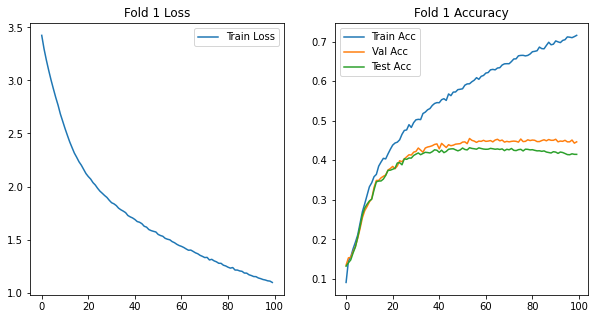

Processing fold 2/5...
Fold 2/5, Epoch 1: Train Loss=3.4324, Train Acc=0.0942, Val Acc=0.1325, Test Acc=0.1268
Fold 2/5, Epoch 2: Train Loss=3.3085, Train Acc=0.1414, Val Acc=0.1463, Test Acc=0.1354
Fold 2/5, Epoch 3: Train Loss=3.1990, Train Acc=0.1556, Val Acc=0.1580, Test Acc=0.1484
Fold 2/5, Epoch 4: Train Loss=3.1007, Train Acc=0.1711, Val Acc=0.1705, Test Acc=0.1614
Fold 2/5, Epoch 5: Train Loss=3.0150, Train Acc=0.1855, Val Acc=0.1777, Test Acc=0.1685
Fold 2/5, Epoch 6: Train Loss=2.9315, Train Acc=0.2038, Val Acc=0.1934, Test Acc=0.1851
Fold 2/5, Epoch 7: Train Loss=2.8570, Train Acc=0.2286, Val Acc=0.2156, Test Acc=0.2130
Fold 2/5, Epoch 8: Train Loss=2.7813, Train Acc=0.2565, Val Acc=0.2606, Test Acc=0.2538
Fold 2/5, Epoch 9: Train Loss=2.6985, Train Acc=0.2860, Val Acc=0.2724, Test Acc=0.2659
Fold 2/5, Epoch 10: Train Loss=2.6327, Train Acc=0.3066, Val Acc=0.2960, Test Acc=0.2833
Fold 2/5, Epoch 11: Train Loss=2.5594, Train Acc=0.3320, Val Acc=0.3057, Test Acc=0.2908
Fold 2/

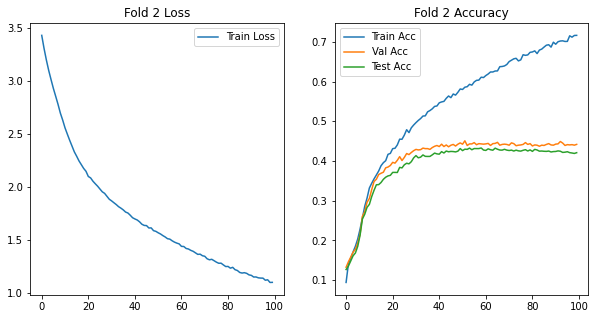

Processing fold 3/5...
Fold 3/5, Epoch 1: Train Loss=3.4271, Train Acc=0.1009, Val Acc=0.1634, Test Acc=0.1325
Fold 3/5, Epoch 2: Train Loss=3.2995, Train Acc=0.1448, Val Acc=0.1653, Test Acc=0.1444
Fold 3/5, Epoch 3: Train Loss=3.1909, Train Acc=0.1643, Val Acc=0.1705, Test Acc=0.1543
Fold 3/5, Epoch 4: Train Loss=3.0924, Train Acc=0.1696, Val Acc=0.1758, Test Acc=0.1635
Fold 3/5, Epoch 5: Train Loss=3.0013, Train Acc=0.1896, Val Acc=0.1908, Test Acc=0.1739
Fold 3/5, Epoch 6: Train Loss=2.9161, Train Acc=0.2105, Val Acc=0.2104, Test Acc=0.1927
Fold 3/5, Epoch 7: Train Loss=2.8400, Train Acc=0.2384, Val Acc=0.2601, Test Acc=0.2353
Fold 3/5, Epoch 8: Train Loss=2.7557, Train Acc=0.2724, Val Acc=0.2863, Test Acc=0.2663
Fold 3/5, Epoch 9: Train Loss=2.6829, Train Acc=0.2942, Val Acc=0.2949, Test Acc=0.2800
Fold 3/5, Epoch 10: Train Loss=2.6063, Train Acc=0.3226, Val Acc=0.3041, Test Acc=0.2879
Fold 3/5, Epoch 11: Train Loss=2.5385, Train Acc=0.3370, Val Acc=0.3125, Test Acc=0.3027
Fold 3/

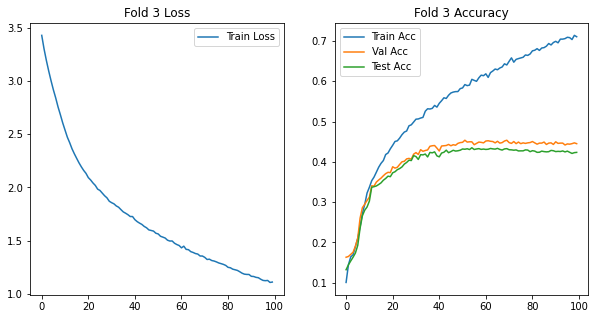

Processing fold 4/5...
Fold 4/5, Epoch 1: Train Loss=3.4220, Train Acc=0.1021, Val Acc=0.1169, Test Acc=0.1183
Fold 4/5, Epoch 2: Train Loss=3.2840, Train Acc=0.1423, Val Acc=0.1332, Test Acc=0.1352
Fold 4/5, Epoch 3: Train Loss=3.1722, Train Acc=0.1558, Val Acc=0.1509, Test Acc=0.1490
Fold 4/5, Epoch 4: Train Loss=3.0808, Train Acc=0.1714, Val Acc=0.1626, Test Acc=0.1636
Fold 4/5, Epoch 5: Train Loss=2.9919, Train Acc=0.1885, Val Acc=0.1771, Test Acc=0.1776
Fold 4/5, Epoch 6: Train Loss=2.9150, Train Acc=0.2171, Val Acc=0.2117, Test Acc=0.2141
Fold 4/5, Epoch 7: Train Loss=2.8386, Train Acc=0.2426, Val Acc=0.2364, Test Acc=0.2429
Fold 4/5, Epoch 8: Train Loss=2.7615, Train Acc=0.2723, Val Acc=0.2547, Test Acc=0.2587
Fold 4/5, Epoch 9: Train Loss=2.6917, Train Acc=0.2964, Val Acc=0.2843, Test Acc=0.2753
Fold 4/5, Epoch 10: Train Loss=2.6177, Train Acc=0.3135, Val Acc=0.2895, Test Acc=0.2859
Fold 4/5, Epoch 11: Train Loss=2.5500, Train Acc=0.3288, Val Acc=0.2994, Test Acc=0.2934
Fold 4/

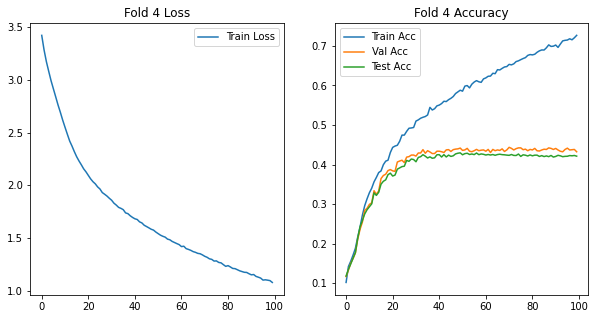

Processing fold 5/5...
Fold 5/5, Epoch 1: Train Loss=3.4201, Train Acc=0.1093, Val Acc=0.1466, Test Acc=0.1296
Fold 5/5, Epoch 2: Train Loss=3.2891, Train Acc=0.1451, Val Acc=0.1538, Test Acc=0.1409
Fold 5/5, Epoch 3: Train Loss=3.1760, Train Acc=0.1568, Val Acc=0.1578, Test Acc=0.1486
Fold 5/5, Epoch 4: Train Loss=3.0797, Train Acc=0.1700, Val Acc=0.1714, Test Acc=0.1613
Fold 5/5, Epoch 5: Train Loss=2.9927, Train Acc=0.1871, Val Acc=0.1780, Test Acc=0.1662
Fold 5/5, Epoch 6: Train Loss=2.9089, Train Acc=0.2063, Val Acc=0.1976, Test Acc=0.1846
Fold 5/5, Epoch 7: Train Loss=2.8302, Train Acc=0.2340, Val Acc=0.2264, Test Acc=0.2251
Fold 5/5, Epoch 8: Train Loss=2.7567, Train Acc=0.2718, Val Acc=0.2584, Test Acc=0.2550
Fold 5/5, Epoch 9: Train Loss=2.6878, Train Acc=0.2957, Val Acc=0.2747, Test Acc=0.2703
Fold 5/5, Epoch 10: Train Loss=2.6134, Train Acc=0.3141, Val Acc=0.2878, Test Acc=0.2870
Fold 5/5, Epoch 11: Train Loss=2.5469, Train Acc=0.3294, Val Acc=0.2996, Test Acc=0.2943
Fold 5/

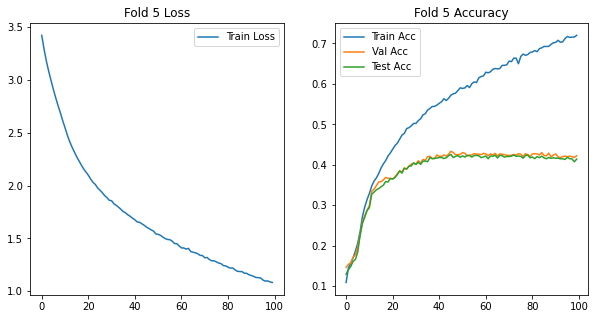

In [131]:
num_epochs = 100
k = 5
learning_rate = 0.2
hidden_dim = 256

Model, Train_acc, Val_acc, Test_acc = k_fold_cross_validation(train_dataset, test_loader, k, num_epochs, batch_size, learning_rate, hidden_dim, device=device, shuffle=True)

In [132]:
TRAIN_acc = np.mean(Train_acc)
print(f"{TRAIN_acc:.4f}")

0.7178


In [133]:
VAL_acc = np.mean(Val_acc)
print(f"{VAL_acc:.4f}")

0.4376


In [134]:
TEST_acc = np.mean(Test_acc)
print(f"{TEST_acc:.4f}")

0.4189
